_Dear Mr. Szecsi!_

 _I send you my sincere thanks for the opportunity to express myself. Also thanks for taking the time to review my work on NBA scoring predictions. It was important and interesting for me.
I especially appreciate the opportunity to share my work about predicting and working with data. If you have any additional comments or questions, I would be pleased to hear your feedback. I really hope for the possibility of further work and my improvement.  Thank you again for your time and attention._


_Best regards,_

_Matthew_

# Technical Interview – Sports Quantitative Analyst/Statistician at OddsMatrix

#### Take-Home Exercise: NBA Player Points Prediction

##### Objective:

Develop a predictive statistical model to estimate the number of points a given NBA player might score in an upcoming match. Ideally try to estimate multiple quantiles of the distribution of points.

##### Background:

The NBA (National Basketball Association) is a major professional basketball league in North America. The league is composed of 30 teams and is one of the major professional sports leagues in the United States and Canada. Players in the NBA vary in terms of their scoring abilities, playing time, roles in their teams, and other factors. Your goal is to leverage historical data to build a model that can predict a player's scoring output on upcoming matches (i.e. using only data available before the match starts).

##### Dataset:

For this exercise, we provide data on the team Miami Heat for the season 2022/23. Data source is the NBA website. Data is split into preseason, season and playoff dataset.

Please make sure that you do not use the playoff period for training or testing, we’ll use it as a holdout dataset for assessing the model!

##### Tasks:

1. Data Exploration: Conduct a preliminary analysis of the dataset. Are there any missing values or outliers? Understand the distribution of key variables.

2. Feature Engineering: Identify which features could be pivotal for the prediction. You might also want to generate new features if necessary.

3. Model Selection: Choose an appropriate statistical or machine learning model for this prediction task. Justify your choice.

4. Model Training: Split the dataset into training and testing subsets. Train your model using the training data.

5. Evaluation: Evaluate your model's performance on the testing data using appropriate metrics. Discuss the results.

6. Prediction: Use the selected model to predict the distribution of points on the holdout set (playoff)

7. Insights & Recommendations: Provide insights based on your model. For example, which features were the most influential in predicting a player's scoring output?

8. Documentation: Write a brief report summarizing your approach, findings, and any challenges you faced. Include code snippets where relevant.

##### Submission Guidelines:

1. Provide a Jupyter Notebook or an equivalent document containing your code, visualizations, and explanations.

2. Include a brief summary or a report detailing your approach, findings, and recommendations.

3. Ensure your code is well-commented, so it's clear what each part of your code is accomplishing.

4. Present your findings to the technical interviewers.

##### Evaluation Criteria:

Your submission will be evaluated based on the following:

· Technical Proficiency: How effectively you handle the data, implement the model, and evaluate its performance.

· Analytical Thinking: Your ability to derive insights from the data and your model.

· Documentation: Clarity and comprehensiveness of your report.

· Code Quality: Cleanliness and readability of your code.

Note: We're mainly interested in your process and approach. Make sure to document and explain your choices at each step.

Good luck!

### Step 1. Exploring the data. Analysing the dataset, checking for missing values and outliers

In [1]:
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
import shap
import numpy as np
import joblib

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from hyperopt import hp
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn import preprocessing
from hyperopt.pyll.base import scope
from sklearn.model_selection import cross_val_score

pd.set_option('display.max_columns', None)

Reading the dataset, and concating preseason and season to one dataframe:

In [2]:
df_season = pd.read_excel('Miami Heat 2022_23 season.xlsx', sheet_name='Season')
df_preseason = pd.read_excel('Miami Heat 2022_23 season.xlsx', sheet_name='Preseason')
df_playoff = pd.read_excel('Miami Heat 2022_23 season.xlsx', sheet_name='Validation aka playoffs')

In [3]:
df_preseason.head()

PLAYER TEAM     MATCH UP  GAME DATE W/L  MIN  PTS  FGM  FGA   FG%  \
0        Max Strus  MIA  MIA vs. NOP 2022-10-12   W   17   11    3    8  37.5   
1     Gabe Vincent  MIA  MIA vs. NOP 2022-10-12   W   17    6    2    5  40.0   
2  Duncan Robinson  MIA  MIA vs. NOP 2022-10-12   W   15    2    1    4  25.0   
3   Victor Oladipo  MIA  MIA vs. NOP 2022-10-12   W   18    2    1    7  14.3   
4   Dewayne Dedmon  MIA  MIA vs. NOP 2022-10-12   W   15    8    3    5  60.0   

   3PM  3PA   3P%  FTM  FTA  FT%  OREB  DREB  REB  AST  STL  BLK  TOV  PF  +/-  
0    3    7  42.9    2    2  100     0     0    0    2    0    0    3   3   -7  
1    2    4    50    0    0    -     0     2    2    1    1    0    1   2   -2  
2    0    3     0    0    0    -     0     4    4    0    0    0    0   2  -14  
3    0    2     0    0    0    -     0     1    1    5    0    0    1   4  -10  
4    1    1   100    1    2   50     1     2    3    1    0    1    0   3    0

In [4]:
df_season.head()

PLAYER TEAM     MATCH UP  GAME DATE W/L  MIN  PTS  FGM  FGA   FG%  \
0      Bam Adebayo  MIA  MIA vs. ORL 2023-04-09   W    8    4    2    3  66.7   
1     Caleb Martin  MIA  MIA vs. ORL 2023-04-09   W   10    2    1    2    50   
2      Cody Zeller  MIA  MIA vs. ORL 2023-04-09   W   12    6    2    2   100   
3  Duncan Robinson  MIA  MIA vs. ORL 2023-04-09   W   35   20    6   14  42.9   
4     Gabe Vincent  MIA  MIA vs. ORL 2023-04-09   W    7    2    1    2    50   

   3PM  3PA   3P%  FTM  FTA   FT%  OREB  DREB  REB  AST  STL  BLK  TOV  PF  \
0    0    0     -    0    0     -     2     1    3    1    1    0    0   0   
1    0    1     0    0    0     -     0     1    1    1    2    0    1   0   
2    0    0     -    2    4    50     1     3    4    2    0    0    0   2   
3    3   11  27.3    5    6  83.3     0     2    2    4    1    0    1   4   
4    0    1     0    0    1     0     0     1    1    0    0    0    0   0   

   +/-  
0    1  
1    2  
2    3  
3    9  
4   -1

In [5]:
df = pd.concat([df_preseason, df_season], ignore_index=True)

In [6]:
df.head()

PLAYER TEAM     MATCH UP  GAME DATE W/L  MIN  PTS  FGM  FGA   FG%  \
0        Max Strus  MIA  MIA vs. NOP 2022-10-12   W   17   11    3    8  37.5   
1     Gabe Vincent  MIA  MIA vs. NOP 2022-10-12   W   17    6    2    5  40.0   
2  Duncan Robinson  MIA  MIA vs. NOP 2022-10-12   W   15    2    1    4  25.0   
3   Victor Oladipo  MIA  MIA vs. NOP 2022-10-12   W   18    2    1    7  14.3   
4   Dewayne Dedmon  MIA  MIA vs. NOP 2022-10-12   W   15    8    3    5  60.0   

   3PM  3PA   3P%  FTM  FTA  FT%  OREB  DREB  REB  AST  STL  BLK  TOV  PF  +/-  
0    3    7  42.9    2    2  100     0     0    0    2    0    0    3   3   -7  
1    2    4    50    0    0    -     0     2    2    1    1    0    1   2   -2  
2    0    3     0    0    0    -     0     4    4    0    0    0    0   2  -14  
3    0    2     0    0    0    -     0     1    1    5    0    0    1   4  -10  
4    1    1   100    1    2   50     1     2    3    1    0    1    0   3    0

In [7]:
for col in df.columns:
    print(f"Unique values of {col}:")
    print(df[col].unique(), end='\n\n')

Unique values of PLAYER:
['Max Strus' 'Gabe Vincent' 'Duncan Robinson' 'Victor Oladipo'
 'Dewayne Dedmon' 'Jamal Cain' 'Jamaree Bouyea' 'Nikola Jovic' 'Dru Smith'
 'Tyler Herro' 'Haywood Highsmith' 'Caleb Martin' 'Bam Adebayo'
 'Jimmy Butler' 'Kyle Lowry' 'Marcus Garrett' 'Orlando Robinson'
 'Mychal Mulder' 'Darius Days' 'Omer Yurtseven' 'Cody Zeller' 'Kevin Love'
 'Udonis Haslem']

Unique values of TEAM:
['MIA']

Unique values of MATCH UP:
['MIA vs. NOP' 'MIA vs. HOU' 'MIA @ MEM' 'MIA @ BKN' 'MIA vs. MIN'
 'MIA vs. ORL' 'MIA @ WAS' 'MIA @ PHI' 'MIA @ DET' 'MIA vs. DAL'
 'MIA @ NYK' 'MIA @ TOR' 'MIA vs. BKN' 'MIA vs. NYK' 'MIA @ CHI'
 'MIA vs. MEM' 'MIA vs. UTA' 'MIA @ ORL' 'MIA vs. CLE' 'MIA vs. ATL'
 'MIA vs. PHI' 'MIA @ CHA' 'MIA @ MIL' 'MIA vs. DEN' 'MIA vs. IND'
 'MIA @ CLE' 'MIA vs. BOS' 'MIA @ DAL' 'MIA @ NOP' 'MIA @ ATL'
 'MIA vs. MIL' 'MIA vs. OKC' 'MIA @ PHX' 'MIA @ LAL' 'MIA @ LAC'
 'MIA @ UTA' 'MIA @ DEN' 'MIA vs. LAL' 'MIA vs. CHI' 'MIA @ SAS'
 'MIA @ HOU' 'MIA @ OKC' 'MIA

In [8]:
df = df.drop(columns=['GAME DATE', 'TEAM'])

 Encoding values using LableEncoder and map method:

In [9]:
match_up_le = preprocessing.LabelEncoder()
df['match_up_enc'] = match_up_le.fit_transform(df['MATCH UP'])

In [10]:
player_le = preprocessing.LabelEncoder()
df['player_enc'] = player_le.fit_transform(df['PLAYER'])

In [11]:
map_method_win_loss = {'W': 0, 'L': 1}
df['win_loss_enc'] = df['W/L'].map(map_method_win_loss)

In [12]:
encoded_df = df.drop(columns = ['PLAYER', 'W/L', 'MATCH UP'])

In [13]:
encoded_df['FT%'] = encoded_df['FT%'].replace('-', 0)
encoded_df['3P%'] = encoded_df['3P%'].replace('-', 0)
encoded_df['FG%'] = encoded_df['FG%'].replace('-', 0)

In [14]:
encoded_df.head()

MIN  PTS  FGM  FGA   FG%  3PM  3PA    3P%  FTM  FTA    FT%  OREB  DREB  \
0   17   11    3    8  37.5    3    7   42.9    2    2  100.0     0     0   
1   17    6    2    5  40.0    2    4   50.0    0    0    0.0     0     2   
2   15    2    1    4  25.0    0    3    0.0    0    0    0.0     0     4   
3   18    2    1    7  14.3    0    2    0.0    0    0    0.0     0     1   
4   15    8    3    5  60.0    1    1  100.0    1    2   50.0     1     2   

   REB  AST  STL  BLK  TOV  PF  +/-  match_up_enc  player_enc  win_loss_enc  
0    0    2    0    0    3   3   -7            46          15             0  
1    2    1    1    0    1   2   -2            46           7             0  
2    4    0    0    0    0   2  -14            46           6             0  
3    1    5    0    0    1   4  -10            46          22             0  
4    3    1    0    1    0   3    0            46           4             0

 Reducing the dataframe weight by changing the data type

In [15]:
encoded_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 838 entries, 0 to 837
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MIN           838 non-null    int64  
 1   PTS           838 non-null    int64  
 2   FGM           838 non-null    int64  
 3   FGA           838 non-null    int64  
 4   FG%           838 non-null    float64
 5   3PM           838 non-null    int64  
 6   3PA           838 non-null    int64  
 7   3P%           838 non-null    float64
 8   FTM           838 non-null    int64  
 9   FTA           838 non-null    int64  
 10  FT%           838 non-null    float64
 11  OREB          838 non-null    int64  
 12  DREB          838 non-null    int64  
 13  REB           838 non-null    int64  
 14  AST           838 non-null    int64  
 15  STL           838 non-null    int64  
 16  BLK           838 non-null    int64  
 17  TOV           838 non-null    int64  
 18  PF            838 non-null    

In [16]:
encoded_df = encoded_df.astype(
    {
        'MIN': 'int8',
        'PTS': 'int8',
        'FGM': 'int8',
        'FGA': 'int8',
        'FG%': 'float64',
        '3PM': 'int8',
        '3PA': 'int8',
        '3P%': 'float64',
        'FTM': 'int8',
        'FTA': 'int8',
        'FT%': 'float64',
        'OREB': 'int8',
        'DREB': 'int8',
        'REB': 'int8',
        'AST': 'int8',
        'STL': 'int8',
        'BLK': 'int8',
        'TOV': 'int8',
        'PF': 'int8',
        '+/-': 'int8',
        'match_up_enc': 'int8',
        'player_enc': 'int8',
        'win_loss_enc': 'int8',
    }
)
encoded_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 838 entries, 0 to 837
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MIN           838 non-null    int8   
 1   PTS           838 non-null    int8   
 2   FGM           838 non-null    int8   
 3   FGA           838 non-null    int8   
 4   FG%           838 non-null    float64
 5   3PM           838 non-null    int8   
 6   3PA           838 non-null    int8   
 7   3P%           838 non-null    float64
 8   FTM           838 non-null    int8   
 9   FTA           838 non-null    int8   
 10  FT%           838 non-null    float64
 11  OREB          838 non-null    int8   
 12  DREB          838 non-null    int8   
 13  REB           838 non-null    int8   
 14  AST           838 non-null    int8   
 15  STL           838 non-null    int8   
 16  BLK           838 non-null    int8   
 17  TOV           838 non-null    int8   
 18  PF            838 non-null    

#### Removing outliers using Interquartile range:

The interquartile range (IQR) is a measure of the spread of the middle 50% of the data. The IQR can be calculated as the difference between the 75th percentile and the 25th percentile of the dataset. Any data point outside the range of 1.5 times the IQR below the 25th percentile or above the 75th percentile can be considered as an outlier.

To identify outliers using the IQR, we use the quantile() function to calculate the 25th and 75th percentiles of the dataset. Then calculate the IQR and use it to identify outliers.

In [17]:
def remove_outliers(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3 - q1 
    fence_low  = q1 - 1.5*iqr
    fence_high = q3 + 1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    outliers = df_in[(df_in[col_name] < q1 - 1.5 * iqr) | (df_in[col_name] > q3 + 1.5 * iqr)]
    return df_out, outliers

In [18]:
df, outliers = remove_outliers(encoded_df, 'PTS')

In [19]:
outliers

MIN  PTS  FGM  FGA   FG%  3PM  3PA   3P%  FTM  FTA    FT%  OREB  DREB  \
206   39   38   14   25  56.0    2    7  28.6    8    8  100.0     1     4   
335   37   38   12   16  75.0    0    0   0.0   14   14  100.0     2     7   
571   38   41   13   20  65.0   10   15  66.7    5    5  100.0     1     5   
655   35   38   15   22  68.2    0    1   0.0    8    8  100.0     3     9   

     REB  AST  STL  BLK  TOV  PF  +/-  match_up_enc  player_enc  win_loss_enc  
206    5    2    1    0    2   2   -8            20          11             1  
335    9    3    1    0    2   2    2            40           0             0  
571    6    2    1    1    4   0    7            10          20             0  
655   12    3    0    0    0   4    1            57           0             0

These rows are outliers, because the number of points in them is too big and differs too much from the others, and if you train the model on raw data with outliers, the model won't be so accurate as it should be.

In [20]:
df.head()

MIN  PTS  FGM  FGA   FG%  3PM  3PA    3P%  FTM  FTA    FT%  OREB  DREB  \
0   17   11    3    8  37.5    3    7   42.9    2    2  100.0     0     0   
1   17    6    2    5  40.0    2    4   50.0    0    0    0.0     0     2   
2   15    2    1    4  25.0    0    3    0.0    0    0    0.0     0     4   
3   18    2    1    7  14.3    0    2    0.0    0    0    0.0     0     1   
4   15    8    3    5  60.0    1    1  100.0    1    2   50.0     1     2   

   REB  AST  STL  BLK  TOV  PF  +/-  match_up_enc  player_enc  win_loss_enc  
0    0    2    0    0    3   3   -7            46          15             0  
1    2    1    1    0    1   2   -2            46           7             0  
2    4    0    0    0    0   2  -14            46           6             0  
3    1    5    0    0    1   4  -10            46          22             0  
4    3    1    0    1    0   3    0            46           4             0

### Step 2. Finding pivotal features for the future predicting

I will use SHAP to find the most important features for future predicting.

In [21]:
y = df.PTS
X = df.drop(columns='PTS')

X.head()

MIN  FGM  FGA   FG%  3PM  3PA    3P%  FTM  FTA    FT%  OREB  DREB  REB  \
0   17    3    8  37.5    3    7   42.9    2    2  100.0     0     0    0   
1   17    2    5  40.0    2    4   50.0    0    0    0.0     0     2    2   
2   15    1    4  25.0    0    3    0.0    0    0    0.0     0     4    4   
3   18    1    7  14.3    0    2    0.0    0    0    0.0     0     1    1   
4   15    3    5  60.0    1    1  100.0    1    2   50.0     1     2    3   

   AST  STL  BLK  TOV  PF  +/-  match_up_enc  player_enc  win_loss_enc  
0    2    0    0    3   3   -7            46          15             0  
1    1    1    0    1   2   -2            46           7             0  
2    0    0    0    0   2  -14            46           6             0  
3    5    0    0    1   4  -10            46          22             0  
4    1    0    1    0   3    0            46           4             0

In [22]:
y.head()

0    11
1     6
2     2
3     2
4     8
Name: PTS, dtype: int8

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [24]:
xgb_regr = xgb.XGBRegressor(n_estimators=20, max_depth=3, learning_rate=.2)

In [25]:
xgb_regr.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=20, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [26]:
y_xgb_regr_pred = xgb_regr.predict(X_test)

In [27]:
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_xgb_regr_pred))

Mean squared error: 0.75


In [28]:
print("Mean absolute error: %.2f" % mean_absolute_error(y_test, y_xgb_regr_pred))

Mean absolute error: 0.46


In [29]:
X_test_sampled = X_test.sample(100, random_state=10)

In [30]:
X_test_sampled.head()

MIN  FGM  FGA   FG%  3PM  3PA   3P%  FTM  FTA   FT%  OREB  DREB  REB  \
84    33    4   11  36.4    1    4  25.0    1    2  50.0     4     5    9   
537   19    0    1   0.0    0    0   0.0    0    0   0.0     1     3    4   
696   30    4   10  40.0    1    3  33.3    9   10  90.0     2     4    6   
619   34    6   10  60.0    4    8  50.0    0    0   0.0     0     0    0   
464   27    4    6  66.7    2    3  66.7    0    0   0.0     0     1    1   

     AST  STL  BLK  TOV  PF  +/-  match_up_enc  player_enc  win_loss_enc  
84     3    1    2    3   3  -12            28           8             1  
537    3    1    2    1   0    8            40           1             1  
696    0    0    0    0   2    6            28          17             1  
619    0    0    0    1   0   -4            14           1             1  
464    3    1    0    0   0   11            30          15             1

In [31]:
explainer = shap.TreeExplainer(xgb_regr)
shap_values = explainer.shap_values(X_test_sampled)

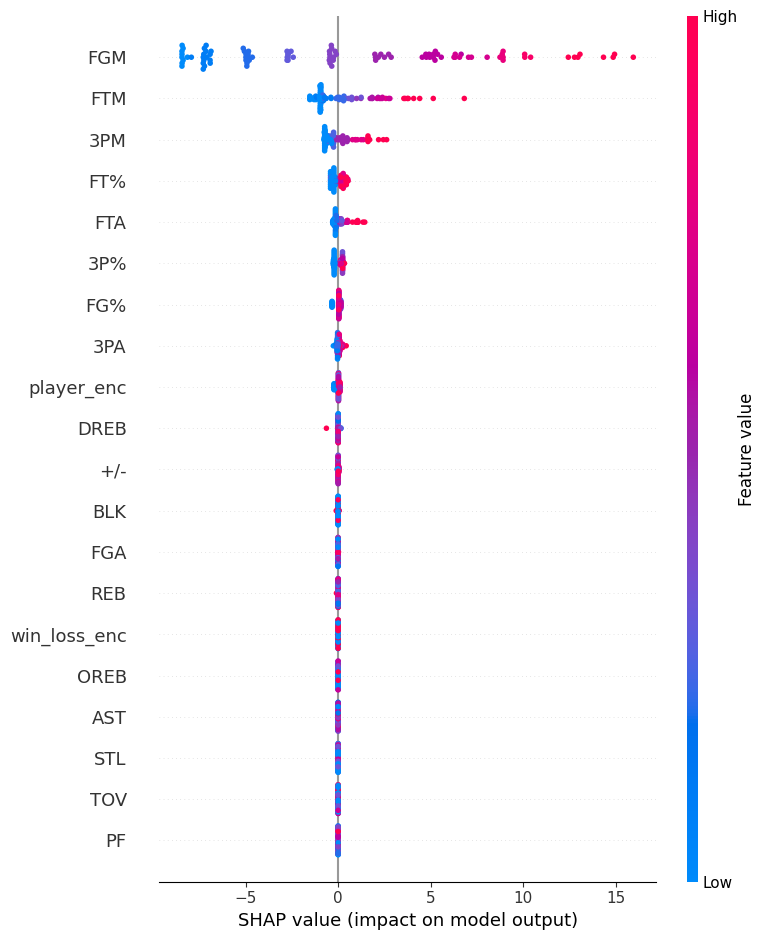

In [32]:
shap.summary_plot(shap_values, X_test_sampled)

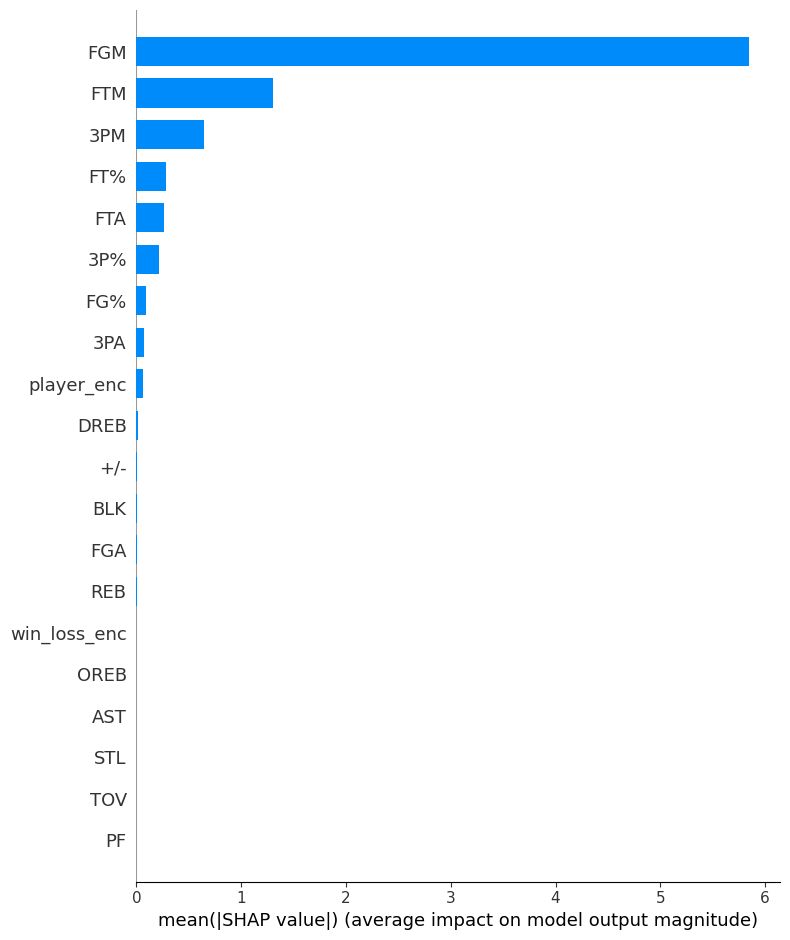

In [33]:
shap.summary_plot(shap_values, X_test_sampled, plot_type='bar')

As we can see the most important features are: FGM, FTM, 3PM, FT%, FTA, 3P%. So, we will make our predictions using these 6 features, so I created a corresponding dataframe.

In [34]:
df_6_features = df[['FGM', 'FTM', '3PM', 'FT%', 'FTA', '3P%', 'PTS']]

### Step 3 - 4. Choosing machine learning model and training it

I decided to try two the most popular and accurate ML models, XGboost and LGBM, and after compare the results and choose one of them for future predicting on playoff set.

In [35]:
df_6_features.head()

FGM  FTM  3PM    FT%  FTA    3P%  PTS
0    3    2    3  100.0    2   42.9   11
1    2    0    2    0.0    0   50.0    6
2    1    0    0    0.0    0    0.0    2
3    1    0    0    0.0    0    0.0    2
4    3    1    1   50.0    2  100.0    8

In [36]:
y = df_6_features.PTS
X = df_6_features.drop(columns=['PTS'])

In [37]:
y.head()

0    11
1     6
2     2
3     2
4     8
Name: PTS, dtype: int8

In [38]:
X.head()

FGM  FTM  3PM    FT%  FTA    3P%
0    3    2    3  100.0    2   42.9
1    2    0    2    0.0    0   50.0
2    1    0    0    0.0    0    0.0
3    1    0    0    0.0    0    0.0
4    3    1    1   50.0    2  100.0

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Now I'm going to find best hyperparameters for xgboost and train it

In [40]:
params_xgb = {
    'max_depth': scope.int(hp.quniform("max_depth", 1, 10, 1)),
    'gamma': hp.uniform ('gamma', 0, 1),
    'reg_alpha' : hp.uniform('reg_alpha', 0, 100),
    'reg_lambda' : hp.uniform('reg_lambda', 0, 100),
    'colsample_bytree': hp.uniform('colsample_bytree', 0, 1),
    'min_child_weight' : hp.uniform('min_child_weight', 0, 20),
    'n_estimators': scope.int(hp.quniform("n_estimators", 1, 1000, 1)),
    'learning_rate': hp.uniform('learning_rate', 0, 1),
    'random_state': scope.int(hp.quniform("random_state", 1, 999999, 1)),
    'max_bin' : scope.int(hp.quniform('max_bin', 2, 512, 1))
}

In [41]:
def hyperparameter_tuning(params_xgb):
    evaluation = [(X_train, y_train)]
    
    model = xgb.XGBRegressor(tree_method='gpu_hist', **params_xgb, eval_metric="mae")

    mae = -cross_val_score(model, X_train, y_train, cv=5, scoring="neg_mean_absolute_error").mean()

    print("SCORE:", mae)
    
    return {'loss': mae, 'status': STATUS_OK}

In [42]:
trials = Trials()
best_hyperparams_for_xgb = fmin(fn=hyperparameter_tuning,
            space=params_xgb,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

SCORE:                                                                                                                 
1.0542741417884827                                                                                                     
SCORE:                                                                                                                 
1.3077632188796997                                                                                                     
SCORE:                                                                                                                 
1.2484899044036866                                                                                                     
SCORE:                                                                                                                 
1.1656596660614014                                                                                                     
SCORE:                                  

SCORE:                                                                                                                 
0.7786771893501282                                                                                                     
SCORE:                                                                                                                 
0.4777910649776459                                                                                                     
SCORE:                                                                                                                 
0.6396148085594178                                                                                                     
SCORE:                                                                                                                 
0.8894388556480408                                                                                                     
SCORE:                                  

In [43]:
best_hyperparams_for_xgb

{'colsample_bytree': 0.14315036671479234,
 'gamma': 0.09049151187358528,
 'learning_rate': 0.6333705766524657,
 'max_bin': 122.0,
 'max_depth': 7.0,
 'min_child_weight': 0.9630765344604644,
 'n_estimators': 998.0,
 'random_state': 212974.0,
 'reg_alpha': 1.4144740479783493,
 'reg_lambda': 74.22337596325158}

In [44]:
xgb_reg = xgb.XGBRegressor(colsample_bytree=best_hyperparams_for_xgb['colsample_bytree'],
                           gamma=best_hyperparams_for_xgb['gamma'],
                           learning_rate=best_hyperparams_for_xgb['learning_rate'],
                           max_bin=int(best_hyperparams_for_xgb['max_bin']),
                           max_depth=int(best_hyperparams_for_xgb['max_depth']), 
                           min_child_weight=int(best_hyperparams_for_xgb['min_child_weight']),
                           n_estimators=int(best_hyperparams_for_xgb['n_estimators']), 
                           random_state=int(best_hyperparams_for_xgb['random_state']),
                           reg_alpha=int(best_hyperparams_for_xgb['reg_alpha']),
                           reg_lambda=best_hyperparams_for_xgb['reg_lambda'],
                             )

In [45]:
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.14315036671479234, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.09049151187358528, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.6333705766524657, max_bin=122,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=0, missing=nan, monotone_constraints=None,
             n_estimators=998, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=212974, ...)

In [46]:
preds = xgb_reg.predict(X_test)
preds_rounded = preds.round()

In [47]:
preds_train = xgb_reg.predict(X_train)
preds_train_rounded = preds_train.round()

### Step 5.1 Now, using aproppriate metrics(mse and mae) i will see is XGboost model accurate for future use

In [49]:
score_mse = mean_squared_error(y_test, preds_rounded)
print('Mean squared error:', score_mse)

Mean squared error: 0.29347825


In [50]:
score_mae = mean_absolute_error(y_test, preds_rounded)
print('Mean absolute error:', score_mae)

Mean absolute error: 0.09057971


In [51]:
score_mse_t = mean_squared_error(y_train, preds_train_rounded)
print('Mean squared error on train part of dataset:', score_mse_t)

Mean squared error on train part of dataset: 0.0609319


In [52]:
score_mae_t = mean_absolute_error(y_train, preds_train_rounded)
print('Mean absolute error on train part of dataset:', score_mae_t)

Mean absolute error on train part of dataset: 0.05376344


In [53]:
joblib.dump(xgb_reg, "xgb_model_v3")

['xgb_model_v3']

Trying LGBM regressor

In [135]:
params_lgb = {
    'learning_rate': hp.uniform('learning_rate',0.1,1),
    'max_depth': hp.choice('max_depth', np.arange(1, 7, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 50, 1, dtype=int)),
    'colsample_bytree': hp.uniform('colsample_bytree', 0, 1),
    'subsample': hp.uniform('subsample', 0.6, 1),
    'num_leaves': hp.choice('num_leaves', np.arange(2, 200, 1, dtype=int)),
    'min_split_gain': hp.uniform('min_split_gain', 0, 1),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'n_estimators': scope.int(hp.quniform("n_estimators", 1, 1000, 1))
}

In [136]:
def hyperparameter_tuning_lgb(params_lgb):
    evaluation = [(X_train, y_train)]
    
    model_lgb = lgb.LGBMRegressor(n_jobs=-1, **params_lgb)

    mae = -cross_val_score(model_lgb, X_train, y_train, cv=5, scoring="neg_mean_absolute_error", n_jobs=-1).mean()

    print("SCORE:", mae)
    
    return {'loss': mae, 'status': STATUS_OK}

In [137]:
trials = Trials()
best_hyperparams_for_lgb = fmin(
    fn=hyperparameter_tuning_lgb,                       
    space=params_lgb,   
    algo=tpe.suggest,            
    max_evals=100,                  
    trials=trials      
)

SCORE:                                                                                                                 
0.5448504693796956                                                                                                     
SCORE:                                                                                                                 
0.7202401874350655                                                                                                     
SCORE:                                                                                                                 
0.49272106565028767                                                                                                    
SCORE:                                                                                                                 
0.6737394217578379                                                                                                     
SCORE:                                  

SCORE:                                                                                                                 
0.44027423415838973                                                                                                    
SCORE:                                                                                                                 
0.4509740590438365                                                                                                     
SCORE:                                                                                                                 
0.48856999049827776                                                                                                    
SCORE:                                                                                                                 
0.5664400763071956                                                                                                     
SCORE:                                  

In [138]:
best_hyperparams_for_lgb

{'colsample_bytree': 0.004262989557657793,
 'learning_rate': 0.4270311095817578,
 'max_depth': 4,
 'min_child_weight': 1,
 'min_split_gain': 0.009117047337192041,
 'n_estimators': 264.0,
 'num_leaves': 82,
 'reg_alpha': 0.8477614678847641,
 'reg_lambda': 0.49455138238741114,
 'subsample': 0.6641368875492014}

In [139]:
lgb_reg = lgb.LGBMRegressor(colsample_bytree=best_hyperparams_for_lgb['colsample_bytree'],
                           learning_rate=best_hyperparams_for_lgb['learning_rate'],
                           max_depth=int(best_hyperparams_for_lgb['max_depth']),
                           min_child_weight=int(best_hyperparams_for_lgb['min_child_weight']),
                           min_split_gain=best_hyperparams_for_lgb['min_split_gain'],
                           n_estimators=int(best_hyperparams_for_lgb['n_estimators']), 
                           num_leaves=int(best_hyperparams_for_lgb['num_leaves']),
                           reg_alpha=int(best_hyperparams_for_lgb['reg_alpha']),
                           reg_lambda=best_hyperparams_for_lgb['reg_lambda'],
                           subsample=best_hyperparams_for_lgb['subsample'],
                             )

In [140]:
lgb_reg.fit(X_train, y_train)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 90
[LightGBM] [Info] Number of data points in the train set: 558, number of used features: 6
[LightGBM] [Info] Start training from score 11.431900
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

LGBMRegressor(colsample_bytree=0.004262989557657793,
              learning_rate=0.4270311095817578, max_depth=4, min_child_weight=1,
              min_split_gain=0.009117047337192041, n_estimators=264,
              num_leaves=82, reg_alpha=0, reg_lambda=0.49455138238741114,
              subsample=0.6641368875492014)

In [141]:
preds_lgb = lgb_reg.predict(X_test)
preds_rounded_lgb = preds_lgb.round()

In [142]:
preds_train_lgb = lgb_reg.predict(X_train)
preds_train_rounded_lgb = preds_train_lgb.round()

In [156]:
joblib.dump(lgb_reg, "lgb_model_v1")

['lgb_model_v1']

### Step 5.2 Now, using aproppriate metrics(mse and mae) i will see accuracy of LGBM.

In [143]:
score_mse_lgb = mean_squared_error(y_test, preds_rounded_lgb)
print('Mean squared error:', score_mse_lgb)

Mean squared error: 1.0036231884057971


In [144]:
score_mae_lgb = mean_absolute_error(y_test, preds_rounded_lgb)
print('Mean absolute error:', score_mae_lgb)

Mean absolute error: 0.22826086956521738


In [145]:
score_mse_t_lgb = mean_squared_error(y_train, preds_train_rounded_lgb)
print('Mean squared error on train part of dataset:', score_mse_t_lgb)

Mean squared error on train part of dataset: 0.32437275985663083


In [146]:
score_mae_t_lgb = mean_absolute_error(y_train, preds_train_rounded_lgb)
print('Mean absolute error on train part of dataset:', score_mae_t_lgb)

Mean absolute error on train part of dataset: 0.14157706093189965


After comparing the results of XGboost and LGBM metrics, I want to say that we should better use XGboost for our future predictions on playoff set, because its results, are better. 

### Step 6

Now, leading to the final part of the main task. In step 6 we are going to predict points on playoff set, using the saved XGboost model('xgb_model_3').

But firstly I need to prepare the set for future prediction.

In [40]:
df_playoff.head()

PLAYER TEAM   MATCH UP            GAME DATE W/L  MIN  PTS  FGM  \
0         Kevin Love  MIA  MIA @ DEN  2023-12-06 00:00:00   L   14    3    1   
1        Bam Adebayo  MIA  MIA @ DEN  2023-12-06 00:00:00   L   44   20    9   
2       Gabe Vincent  MIA  MIA @ DEN  2023-12-06 00:00:00   L   22    6    3   
3  Haywood Highsmith  MIA  MIA @ DEN  2023-12-06 00:00:00   L    3    0    0   
4          Max Strus  MIA  MIA @ DEN  2023-12-06 00:00:00   L   32   12    5   

   FGA   FG%  3PM  3PA   3P%  FTM  FTA  FT%  OREB  DREB  REB  AST  STL  BLK  \
0    4  25.0    1    4  25.0    0    0    -     0     2    2    0    1    2   
1   20  45.0    0    0     -    2    2  100     5     7   12    1    1    0   
2   13  23.1    0    4   0.0    0    0    -     0     0    0    3    1    0   
3    0     -    0    0     -    0    0    -     0     1    1    0    0    0   
4   12  41.7    1    6  16.7    1    1  100     1     7    8    1    0    1   

   TOV  PF  +/-  
0    0   1  -11  
1    1   2   -3  
2    0   2  -14  
3    0   1    0  
4    1   3    2

In [41]:
df_playoff_6_features = df_playoff[['FGM', 'FTM', '3PM', 'FT%', 'FTA', '3P%', 'PTS']]
df_playoff_6_features['FT%'] = df_playoff_6_features['FT%'].replace('-', 0)
df_playoff_6_features['3P%'] = df_playoff_6_features['3P%'].replace('-', 0)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [42]:
df_playoff_6_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238 entries, 0 to 237
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   FGM     238 non-null    int64 
 1   FTM     238 non-null    int64 
 2   3PM     238 non-null    int64 
 3   FT%     238 non-null    object
 4   FTA     238 non-null    int64 
 5   3P%     238 non-null    object
 6   PTS     238 non-null    int64 
dtypes: int64(5), object(2)
memory usage: 13.1+ KB


In [43]:
df_playoff_6_features = df_playoff_6_features.astype(
    {
        'PTS': 'int8',
        'FGM': 'int8',
        '3PM': 'int8',
        '3P%': 'float64',
        'FTA': 'int8',
        'FTM': 'int8',
        'FT%': 'float64'
    }
)
df_playoff_6_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238 entries, 0 to 237
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   FGM     238 non-null    int8   
 1   FTM     238 non-null    int8   
 2   3PM     238 non-null    int8   
 3   FT%     238 non-null    float64
 4   FTA     238 non-null    int8   
 5   3P%     238 non-null    float64
 6   PTS     238 non-null    int8   
dtypes: float64(2), int8(5)
memory usage: 5.0 KB


In [44]:
y_playoff = df_playoff_6_features.PTS
X_playoff = df_playoff_6_features.drop(columns=['PTS'])

In [45]:
y_playoff.head()

0     3
1    20
2     6
3     0
4    12
Name: PTS, dtype: int8

In [46]:
X_playoff.head()

FGM  FTM  3PM    FT%  FTA   3P%
0    1    0    1    0.0    0  25.0
1    9    2    0  100.0    2   0.0
2    3    0    0    0.0    0   0.0
3    0    0    0    0.0    0   0.0
4    5    1    1  100.0    1  16.7

In [47]:
xgb_reg = joblib.load('xgb_model_v3')
xgb_reg

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.14315036671479234, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.09049151187358528, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.6333705766524657, max_bin=122,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=0, missing=nan, monotone_constraints=None,
             n_estimators=998, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=212974, ...)

In [48]:
preds_playoff = xgb_reg.predict(X_playoff)
preds_playoff_rounded = preds_playoff.round()

In [49]:
preds_playoff_rounded

array([ 3., 20.,  6.,  0., 12., 12., 21.,  0., 10.,  5.,  0., 13., 12.,
        0., 12.,  2., 11., 26., 20.,  0.,  0.,  6.,  7.,  9., 10., 28.,
        0., 22.,  9.,  0.,  0.,  0.,  3., 23.,  0., 14.,  9., 21.,  3.,
        6., 21.,  4., 10., 13.,  0., 18., 19.,  3., 25., 11.,  0.,  0.,
        0.,  3., 10., 10.,  2.,  8.,  0.,  0.,  7., 27., 12., 26., 15.,
       13., 21., 11., 24.,  8., 10.,  1.,  4., 16.,  3., 15.,  5.,  0.,
        2.,  6., 14., 14., 18.,  2., 16.,  5.,  0.,  6., 29.,  9.,  0.,
        0., 17.,  5., 10.,  5., 16., 13.,  2.,  2.,  0.,  7., 18., 29.,
        4., 22., 10.,  9., 15., 24., 21.,  0., 11.,  2., 27.,  0.,  0.,
       36., 15., 15.,  0., 20.,  8., 15., 15.,  0.,  6.,  8., 23., 25.,
       11., 14.,  7.,  3., 17., 11.,  5., 19.,  9., 14.,  0.,  6., 18.,
        4., 23.,  2., 27.,  3., 16., 15.,  8., 10.,  3.,  2.,  6.,  5.,
        4.,  3., 14.,  0.,  0., 19.,  5., 17.,  4., 29.,  8., 15.,  5.,
       17.,  6., 22.,  9., 21.,  2.,  0.,  9., 25., 18., 16.,  9

In [50]:
score_mse_playoff = mean_squared_error(y_playoff, preds_playoff_rounded)
print('Mean squared error:', score_mse_playoff)

Mean squared error: 1.1932774


In [51]:
score_mae_playoff = mean_absolute_error(y_playoff, preds_playoff_rounded)
print('Mean absolute error:', score_mae_playoff)

Mean absolute error: 0.15126051


In [76]:
preds_playoff

array([ 2.942452  , 19.909018  ,  5.987916  ,  0.06092089, 12.009355  ,
       12.157037  , 21.1689    ,  0.06092089, 10.06023   ,  4.9792666 ,
        0.06092089, 13.105077  , 12.413632  ,  0.06092089, 12.079562  ,
        1.9787908 , 11.023427  , 25.829985  , 19.708256  ,  0.06092089,
        0.06092089,  5.99215   ,  6.765998  ,  8.849283  ,  9.980004  ,
       27.508034  ,  0.06092089, 21.96653   ,  8.909814  ,  0.06092089,
        0.06092089,  0.06092089,  2.942452  , 23.11152   ,  0.06092089,
       13.808133  ,  9.341341  , 20.610264  ,  3.0607781 ,  6.035401  ,
       20.71274   ,  3.958292  ,  9.778892  , 13.046895  ,  0.06092089,
       18.108519  , 19.098675  ,  2.9714618 , 25.149084  , 10.807517  ,
        0.06092089,  0.06092089,  0.06092089,  3.0607781 ,  9.925666  ,
        9.925666  ,  1.9787908 ,  8.065025  ,  0.06092089,  0.06092089,
        7.0699043 , 27.465046  , 11.866719  , 25.514935  , 14.826272  ,
       12.802806  , 20.997936  , 11.008858  , 23.854406  ,  8.10

In [77]:
preds_playoff_rounded

array([ 3., 20.,  6.,  0., 12., 12., 21.,  0., 10.,  5.,  0., 13., 12.,
        0., 12.,  2., 11., 26., 20.,  0.,  0.,  6.,  7.,  9., 10., 28.,
        0., 22.,  9.,  0.,  0.,  0.,  3., 23.,  0., 14.,  9., 21.,  3.,
        6., 21.,  4., 10., 13.,  0., 18., 19.,  3., 25., 11.,  0.,  0.,
        0.,  3., 10., 10.,  2.,  8.,  0.,  0.,  7., 27., 12., 26., 15.,
       13., 21., 11., 24.,  8., 10.,  1.,  4., 16.,  3., 15.,  5.,  0.,
        2.,  6., 14., 14., 18.,  2., 16.,  5.,  0.,  6., 29.,  9.,  0.,
        0., 17.,  5., 10.,  5., 16., 13.,  2.,  2.,  0.,  7., 18., 29.,
        4., 22., 10.,  9., 15., 24., 21.,  0., 11.,  2., 27.,  0.,  0.,
       36., 15., 15.,  0., 20.,  8., 15., 15.,  0.,  6.,  8., 23., 25.,
       11., 14.,  7.,  3., 17., 11.,  5., 19.,  9., 14.,  0.,  6., 18.,
        4., 23.,  2., 27.,  3., 16., 15.,  8., 10.,  3.,  2.,  6.,  5.,
        4.,  3., 14.,  0.,  0., 19.,  5., 17.,  4., 29.,  8., 15.,  5.,
       17.,  6., 22.,  9., 21.,  2.,  0.,  9., 25., 18., 16.,  9

In [78]:
comparing = np.array(y_playoff == preds_playoff_rounded)
print(comparing)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True False  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
 False  True  True  True  True  True  True  True  True  True  True  True
  True False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True False False  True  True  True  True  True  True False  True  True
  True  True  True  True  True  True  True  True  True False  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  T

In [85]:
list(comparing).count(False)

12

As we can see, only 12 predictions out of 238 are wrong, where the average error is 1. But we also have 3 completely wrong values. In the playoff set it is [42, 56, 35], but the model is predicted [33, 43, 30]. Comparing below similar cases from the season and preseason dataframes, we can consider values [42, 56, 35] to be otliers.

In [79]:
preds_playoff_rounded[~comparing]

array([26., 25., 27., 24., 21., 36., 25., 29., 21., 33., 43., 30.],
      dtype=float32)

In [80]:
y_playoff[~comparing].to_numpy()

array([25, 26, 28, 25, 22, 35, 24, 28, 20, 42, 56, 35], dtype=int8)

In [90]:
df_6_features[df_6_features.PTS >= 33]

FGM  FTM  3PM    FT%  FTA    3P%  PTS
114   12   10    1   90.9   11   33.3   35
138   13    1    6  100.0    1   60.0   33
155   11   11    2   78.6   14  100.0   35
217   12    8    1   88.9    9  100.0   33
253    7   18    1   90.0   20   50.0   33
286   10    7    6  100.0    7   50.0   33
430   11   11    1  100.0   11  100.0   34
455    6   23    0  100.0   23    0.0   35
580   12    2    9  100.0    2   52.9   35
616   12    8    2  100.0    8   50.0   34
731   11   13    0   86.7   15    0.0   35
776   13    3    5   75.0    4   62.5   34

In [91]:
df_playoff_6_features[df_playoff_6_features.PTS >= 33]

FGM  FTM  3PM   FT%  FTA   3P%  PTS
117   12    9    2  90.0   10  50.0   35
189   17    5    3  55.6    9  30.0   42
201   19   15    3  83.3   18  37.5   56
231   15    5    0  62.5    8   0.0   35

### Step 7 

In conclusion, I can say that I have analyzed the dataframe, identified outliers, and found the best hyperparameters for my model. Also I found the main features for prediction, they are: Field Goals Made, Free Throws Made, 3 Point Field Goals Made, Free Throw Percentage, Free Throws Attempted, 3 Point Field Goal Percentage. As a result, the model predicts the number of points that players can score accurate to 0.15, if don't take the outliers into account.